# Face Detection

Face detection is a computer vision technique used to locate and identify human faces within images or video frames. It plays a crucial role in various applications, such as facial recognition, emotion detection, face tracking, and more.

To train a face detector, lets collect a database with images and proper annotations.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import os
import pathlib
import PIL
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import cv2 as cv
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense,Dropout, BatchNormalization

Remember, initialize the GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


Images stored in a folder, together with a CSV file with annotations

In [3]:
images_path = "../large_datasets/faces/images"
dataset_path = "../large_datasets/faces/faces.csv"

dataset = pd.read_csv(dataset_path)
dataset.head()

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


If many faces in the same file, each face appears in a different row

In [4]:
dataset['image_name'].value_counts()

image_name
00000657.jpg    12
00003172.jpg    11
00003165.jpg    11
00000508.jpg    10
00000737.jpg     9
                ..
00003430.jpg     1
00003418.jpg     1
00001569.jpg     1
00002074.jpg     1
00000103.jpg     1
Name: count, Length: 2204, dtype: int64

Lets show the image with more faces

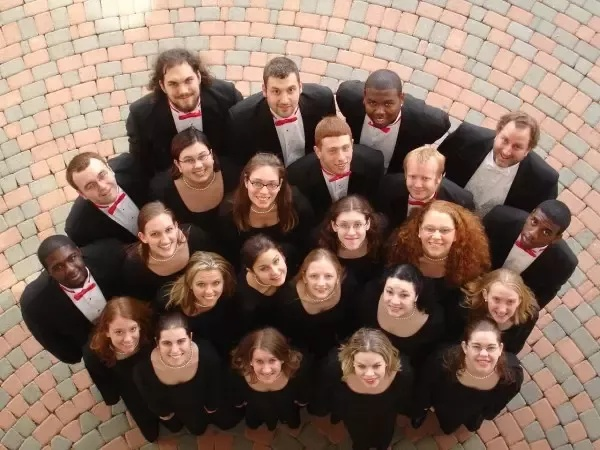

In [5]:
from IPython.display import Image

Image(filename=os.path.join(images_path, "00000657.jpg"), width=400, height=300)

Lets show images with annotated faces

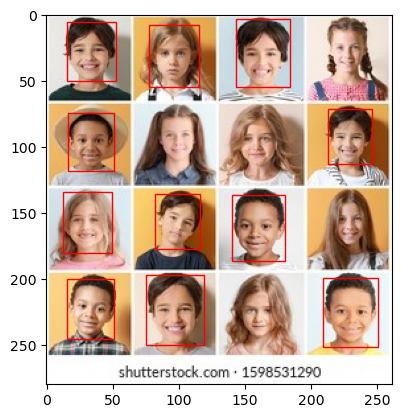

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd


# Specify the image name for which you want to draw rectangles
target_image_name = '00003172.jpg'

# Filter the DataFrame to get the relevant rows for the target image
target_df = dataset[dataset['image_name'] == target_image_name]

# Load and display the target image
image_path = os.path.join(images_path, target_image_name)  # Adjust the path to your image directory

# Create a figure and axes
fig, ax = plt.subplots(1)

image = plt.imread(image_path)
ax.imshow(image)


# Iterate over the rows of the target DataFrame and draw rectangles
for index, row in target_df.iterrows():
    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    width = x1 - x0
    height = y1 - y0
    rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()


**Note**. Like in many resources available in internet, there are errors in the annotations!
- This will significantly degrades the quality of any model obtained using is.

Lest put all the annotations of every image together

In [7]:
data = {}
for i in dataset["image_name"]:
    if i not in data:
        data[i] = []
for index, img_name in enumerate(dataset["image_name"]):
    width = dataset["width"][index]
    height = dataset["height"][index]
    x0 = dataset["x0"][index]
    x1 = dataset["x1"][index]
    y0 = dataset["y0"][index]
    y1 = dataset["y1"][index]
    
    new_x0 = int((x0/width)*224)
    new_x1 = int((x1/width)*224)
    new_y0 = int((y0/width)*224)
    new_y1 = int((y1/width)*224)
    
    data[img_name].append(new_x0)
    data[img_name].append(new_x1)
    data[img_name].append(new_y0)
    data[img_name].append(new_y1)

In [8]:
print(data['00001736.jpg'])
print(data['00002997.jpg'])
print(data['00003121.jpg'])

[52, 185, 5, 108]
[68, 92, 62, 80, 94, 122, 5, 27, 144, 173, 28, 51]
[165, 214, 21, 59, 113, 157, 56, 90, 12, 57, 25, 60, 90, 134, 33, 66, 59, 109, 42, 80]


Read all the images, resizing them to 224x224

In [9]:
img_dir = os.listdir(images_path)
images = []
for img_name in data.keys():
    for itr in img_dir:
        if img_name == itr:
            img_arr = cv.imread(os.path.join(images_path, img_name),
                               cv.IMREAD_GRAYSCALE)
            img_resize = cv.resize(img_arr, (224, 224))
            images.append(img_resize)

Convert images to a numpy array and add a new dimension (will be clear in the CNN lecture).

In [10]:
images = np.array(images)
images = np.expand_dims(images, axis = 3)

In [11]:
print(f"Shape of images : {images.shape}")

Shape of images : (2204, 224, 224, 1)


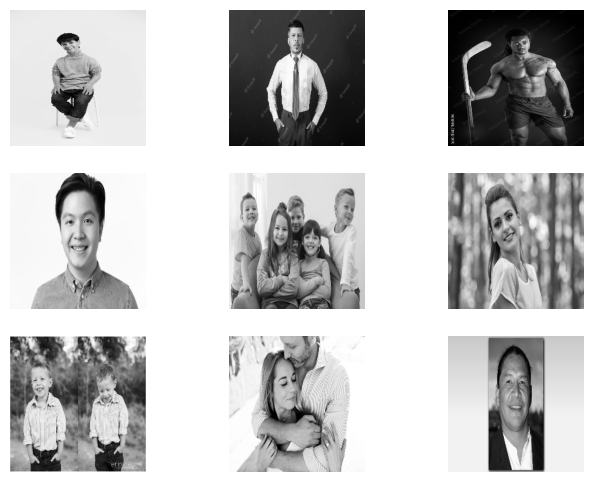

In [12]:
plt.figure(figsize = (8,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap = 'gray')
    plt.axis('off')

## Creating BBoxes (or Bounding Boxes) for Object Detection

We transform the bounding boxes to be used to train the network. 
- The network uses a fixed number of output values (one per output neuron).
- There are figures with different number of boxes
- Solution: Transform all using the largest number of boxes. If some figure has less boxes, zeros are used

In [13]:
bbox = []
for box in data.keys():
    bbox.append(data[box])

max_bbox = 0
for i in range(len(bbox)):
    max_bbox = max(max_bbox, len(bbox[i]))

for i in range(len(bbox)):
    if int(max_bbox) - len(bbox[i]) != 0:
        for j in range(int(max_bbox) - len(bbox[i])):
            bbox[i].append(0)

In [14]:
bbox = np.array(bbox)
print(bbox[0])
print(bbox[4])

[ 82 115  53 111   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[165 214  21  59 113 157  56  90  12  57  25  60  90 134  33  66  59 109
  42  80   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [15]:
bbox.shape

(2204, 48)

In [16]:
# Lets normalize
images = images/255
bbox = bbox/224

In [17]:
#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, bbox, test_size = 0.25, random_state = 42)

In [18]:
# Building a CNN Sequential Model

model = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(64, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(128, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(256, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer has 48 neurons to match the bbox dimensions
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [20]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['accuracy'])

In [21]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), epochs = 10, batch_size=16)

Epoch 1/10
104/104 [==============================] - 6s 25ms/step - loss: 0.2181 - accuracy: 0.4652 - val_loss: 0.1259 - val_accuracy: 0.6806
Epoch 2/10
104/104 [==============================] - 2s 19ms/step - loss: 0.1251 - accuracy: 0.6854 - val_loss: 0.1270 - val_accuracy: 0.6806
Epoch 3/10
104/104 [==============================] - 2s 19ms/step - loss: 0.1232 - accuracy: 0.6854 - val_loss: 0.1265 - val_accuracy: 0.6806
Epoch 4/10
104/104 [==============================] - 2s 19ms/step - loss: 0.1226 - accuracy: 0.6854 - val_loss: 0.1236 - val_accuracy: 0.6806
Epoch 5/10
104/104 [==============================] - 2s 20ms/step - loss: 0.1218 - accuracy: 0.6854 - val_loss: 0.1260 - val_accuracy: 0.6806
Epoch 6/10
104/104 [==============================] - 2s 20ms/step - loss: 0.1219 - accuracy: 0.6854 - val_loss: 0.1237 - val_accuracy: 0.6806
Epoch 7/10
104/104 [==============================] - 2s 19ms/step - loss: 0.1210 - accuracy: 0.6854 - val_loss: 0.1237 - val_accuracy: 0.6806

Plotting code adapted from Daniel Bourke's Course on TensorFlow and Deep Learning

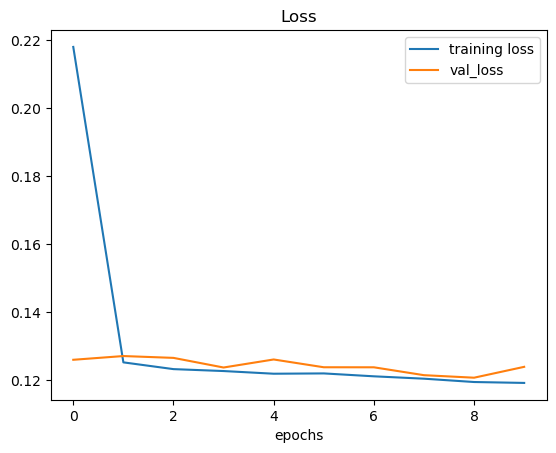

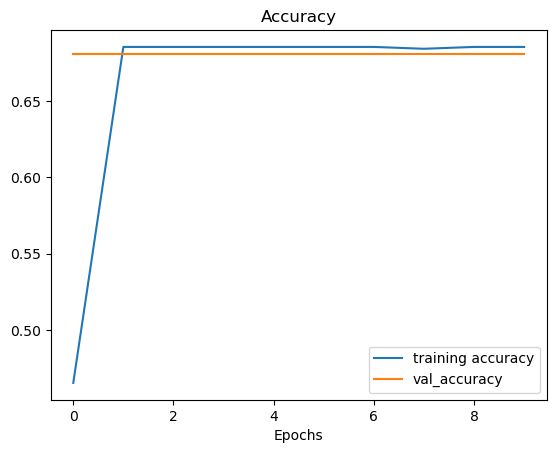

In [22]:
def plot_loss_curves(history):
    '''
    Returns separate loss curves for training and validation metrics
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) #generates the sequence of indices in a list, in this case epochs

    #Plot loss
    plt.plot(epochs, loss, label = 'training loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

    #Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
plot_loss_curves(history)

In [23]:
model.evaluate(X_test, y_test, batch_size = 32)

18/18 [==============================] - 0s 10ms/step - loss: 0.1238 - accuracy: 0.6806


[0.12382581830024719, 0.680580735206604]

## Model 2: Adding a BatchNormalisation and Dropout Layer

If you want to improve the results, you can do some modifications in the network layers or the parameters, or both.
- In this case, we add BatchNormalization and Dropout layers

In [24]:
model_2 = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    Dropout(0.2),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    Dropout(0.3),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(256, 3, activation = 'relu'),
    Dropout(0.4),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)     

In [25]:
model_2.compile(loss = 'binary_crossentropy',
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [26]:
history_2 = model_2.fit(X_train, y_train, validation_data = (X_test, y_test),
           batch_size = 8, epochs = 10)

Epoch 1/10
207/207 [==============================] - 7s 22ms/step - loss: 0.1590 - accuracy: 0.6316 - val_loss: 0.1348 - val_accuracy: 0.6806
Epoch 2/10
207/207 [==============================] - 4s 19ms/step - loss: 0.1186 - accuracy: 0.6685 - val_loss: 0.1737 - val_accuracy: 0.6806
Epoch 3/10
207/207 [==============================] - 4s 19ms/step - loss: 0.1150 - accuracy: 0.6558 - val_loss: 0.1365 - val_accuracy: 0.6806
Epoch 4/10
207/207 [==============================] - 4s 19ms/step - loss: 0.1136 - accuracy: 0.6673 - val_loss: 0.1392 - val_accuracy: 0.6806
Epoch 5/10
207/207 [==============================] - 4s 19ms/step - loss: 0.1096 - accuracy: 0.6564 - val_loss: 0.1293 - val_accuracy: 0.6806
Epoch 6/10
207/207 [==============================] - 4s 19ms/step - loss: 0.1079 - accuracy: 0.6842 - val_loss: 0.1484 - val_accuracy: 0.6806
Epoch 7/10
207/207 [==============================] - 4s 20ms/step - loss: 0.1072 - accuracy: 0.6800 - val_loss: 0.1502 - val_accuracy: 0.6806

Slight improvement in the accuracy over the previous model.

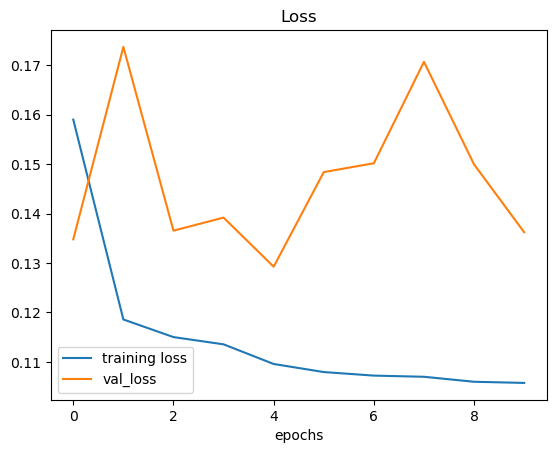

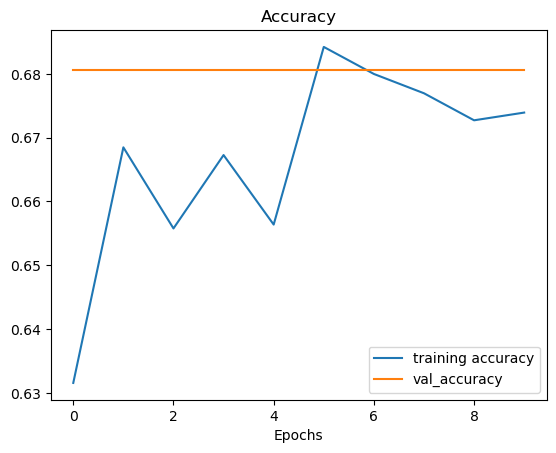

In [27]:
plot_loss_curves(history_2)

Lets evaluate the new model

In [28]:
model_2.evaluate(X_test, y_test, batch_size = 32)

18/18 [==============================] - 0s 10ms/step - loss: 0.1362 - accuracy: 0.6806


[0.13622470200061798, 0.680580735206604]

Now, lets see some detections on images

In [29]:
def plot_predictions(model,idx):
    '''
    Plots the decision boundary for a model on an image specified by its index.
    
    Parameters:
    
    model: The model whose predictions we are testing
    idx: The index of the image as it appears in the dataset
    '''
    model_prediction = model.predict(X_test[idx].reshape(1, 224, 224, 1))
    model_prediction = model_prediction[0]
    img = X_test[idx]
    count = 0
    bbox1 = []
    for i in model_prediction:
        bbox1.append(i)
        count+=1
        if count == 4:
            count = 0
            plt.subplot(1,2,1)
            plt.imshow(img)
            x1 = int(bbox1[0]*224)
            y1 = int(bbox1[1]*224)
            x2 = int(bbox1[2]*224)
            y2 = int(bbox1[3]*224)
            plt.gca().add_patch(matplotlib.patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth = 1,
                                                 edgecolor = 'r', facecolor = "none"))
            bbox1 = []
    plt.show()

1/1 [==============================] - 0s 99ms/step


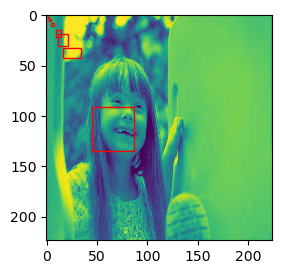

In [30]:
plot_predictions(model,4)

1/1 [==============================] - 0s 105ms/step


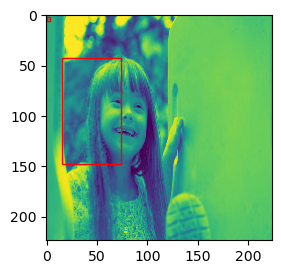

In [31]:
plot_predictions(model_2, 4)

**Note**. This is only a demo for teaching purposes. For real face detection we need to use a different kind of neural network (Convolutional NN) and much more complex network architectures.